In [459]:
import sys
import os
sys.path.append("../../modules/")
import helper as hp
import matplotlib.pyplot as plt
%matplotlib inline
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.updates import *
from lasagne.objectives import *
from skimage.io import imread
from skimage import img_as_float

In [460]:
train_data, valid_data, test_data = hp.load_mnist("../../data/mnist.pkl.gz")

In [461]:
Xt, yt = train_data

In [462]:
Xt9 = Xt[ yt == 9 ]

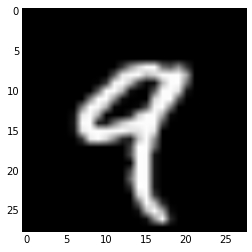

In [463]:
plt.imshow(Xt9[0][0], cmap="gray")

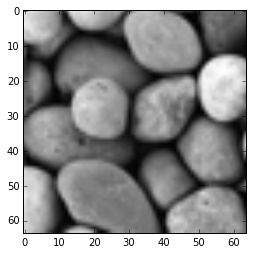

In [159]:
plt.imshow( img_as_float(imread("rocks2.png")), cmap="gray" )

In [164]:
rock = imread("rocks2.jpg") / 255.0
rock

array([[ 0.77254902,  0.76078431,  0.76078431, ...,  0.37647059,
         0.37647059,  0.3254902 ],
       [ 0.79215686,  0.72941176,  0.73333333, ...,  0.31764706,
         0.33333333,  0.29019608],
       [ 0.78039216,  0.7372549 ,  0.70980392, ...,  0.34509804,
         0.33333333,  0.30588235],
       ..., 
       [ 0.72156863,  0.70196078,  0.65490196, ...,  0.51764706,
         0.47058824,  0.32156863],
       [ 0.7254902 ,  0.70196078,  0.69803922, ...,  0.54901961,
         0.48627451,  0.34901961],
       [ 0.74509804,  0.67843137,  0.65882353, ...,  0.50196078,
         0.44705882,  0.34901961]])

In [165]:
rock = rock.reshape((1, 1, rock.shape[0], rock.shape[1]))

In [213]:
?MaxPool2DLayer

In [736]:
def conv_net(input_shape=(1,1,28,28), umin=0, umax=1):
    
    nonlinearity=tanh
    l_in = InputLayer(input_shape)
    
    l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(3,3), nonlinearity=nonlinearity)
    l_exp1 = ExpressionLayer(l_conv1, lambda X: X, output_shape='auto')
    l_mp1 = MaxPool2DLayer(l_exp1, pool_size=(2,2))
    
    l_conv2 = Conv2DLayer(l_mp1, num_filters=32, filter_size=(3,3), nonlinearity=nonlinearity)
    l_exp2 = ExpressionLayer(l_conv2, lambda X: X, output_shape='auto')
    l_mp2 = MaxPool2DLayer(l_exp2, pool_size=(2,2))
    
    l_conv3 = Conv2DLayer(l_mp2, num_filters=64, filter_size=(3,3), nonlinearity=nonlinearity)
    l_exp3 = ExpressionLayer(l_conv3, lambda X: X, output_shape='auto')
    l_mp3 = Pool2DLayer(l_exp3, pool_size=(2,2))
    
    #l_conv4 = Conv2DLayer(l_mp3, num_filters=64, filter_size=(3,3))
    #l_mp4 = Pool2DLayer(l_conv4, pool_size=(2,2), mode='average_inc_pad')
    l_out = l_mp3
    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    outs = []
    X = T.tensor4('X')
    #Y = T.tensor4('Y')
    Y = theano.shared( np.random.uniform(umin, umax, size=input_shape ) )
    
    for layer in get_all_layers(l_out):
        # if the image is (bs, 1, f1, f2),
        # we want: (bs, 1*f1*f2) = (bs, f1*f2),
        # where f1 and f2 is the width/height of the feature map
        get_out = get_output(layer, X)
        outs.append( get_out.reshape( (get_out.shape[1], get_out.shape[2]*get_out.shape[3]) ) )
    
    loss_fn = 0
    for layer in get_all_layers(l_out):
        sys.stderr.write("%s,%s\n" % (str(layer), str(layer.output_shape)))
        if isinstance(layer, InputLayer):
            continue
        # compute the F matrix for actual image
        get_out_X = get_output(layer, X, deterministic=True)
        get_out_X = get_out_X.reshape((get_out_X.shape[1], get_out_X.shape[2]*get_out_X.shape[3]) )
        # compute the F matrix for noisy image
        get_out_Y = get_output(layer, Y, deterministic=True)
        get_out_Y = get_out_Y.reshape((get_out_Y.shape[1], get_out_Y.shape[2]*get_out_Y.shape[3]) )
        # (F_actual - F_noise)^2 then flatten then mean
        loss_fn += squared_error(
            T.dot(get_out_X, get_out_X.T), T.dot(get_out_Y, get_out_Y.T)
        ).mean()
    # (bs,1) + (b/s,1) + ... + (bs,1)
    # then (bs,1).mean() = (1)
    #loss_fn = loss_fn.mean()
    # T.dot(get_out_X.T, get_out_X), T.dot(get_out_Y.T, get_out_Y)
    
    tmp = theano.function([X], T.grad(loss_fn, [Y]))
    
    #theano.printing.pydotprint(
    #    loss_fn, outfile="/tmp/loss_fn.png", var_with_name_simple=True) 
        
    updates = sgd(loss_fn, get_all_params(l_out) + [Y], 0.0001)
    #updates = rmsprop(loss_fn, get_all_params(l_out) + [Y], 0.01)
    
    scale_updates = []
    for param in get_all_params(l_out):
        scale_updates.append( ( param, (param - T.mean(param))/T.std(param) ) )
    post = theano.function([], [], updates=scale_updates)
    print scale_updates
    
    get_outs = theano.function([X], outs)
    train = theano.function([X], [loss_fn, T.mean(T.abs_(T.grad(loss_fn, [Y])))], updates=updates)
    return {"get_outs": get_outs, "l_out": l_out, "train": train, "Y": Y, "post": post}

In [737]:
cn = conv_net(Xt9[0:1].shape, umin=0, umax=1)

number of params: 23296
<lasagne.layers.input.InputLayer object at 0x11d2244d0>,(1, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x120964e10>,(1, 16, 26, 26)
<lasagne.layers.special.ExpressionLayer object at 0x1403b7410>,(1, 16, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x1130d4910>,(1, 16, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x13ad14490>,(1, 32, 11, 11)
<lasagne.layers.special.ExpressionLayer object at 0x13ad14290>,(1, 32, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x12c53bb10>,(1, 32, 5, 5)
<lasagne.layers.conv.Conv2DLayer object at 0x13f1a6950>,(1, 64, 3, 3)


[(W, Elemwise{true_div,no_inplace}.0), (b, Elemwise{true_div,no_inplace}.0), (W, Elemwise{true_div,no_inplace}.0), (b, Elemwise{true_div,no_inplace}.0), (W, Elemwise{true_div,no_inplace}.0), (b, Elemwise{true_div,no_inplace}.0)]


<lasagne.layers.special.ExpressionLayer object at 0x13f1a6d50>,(1, 64, 3, 3)
<lasagne.layers.pool.Pool2DLayer object at 0x13002ca50>,(1, 64, 1, 1)


In [741]:
print cn["train"](Xt9[0:1])
print cn["post"]()

[array(209139.37840949648), array(1128.2316194565265)]
[]


In [ ]:
"""
"Finally, for practical reasons, we rescaled the weights in the network such that the mean activation of each filter
over images and positions is equal to one. Such re-scaling can always be done without changing the
output of a neural network if the non-linearities in the network are rectifying linear"
"""

In [728]:
check_every=100
for i in range(0,100):
    loss, _ = cn["train"](Xt9[0:1])
    cn["post"]()
    print loss
    #if i % check_every == 0:
    #    print loss

1.38163990545
1.32138492903
1.48684449353
1.73087113286
2.44771589755
3.67956979883
5.30609672349
5.75042111463
4.54746927954
3.47708910468
3.30407946628
4.16479086396
6.43508648213
5.97043692253
6.00107197337
3.84340003773
3.06290866247
2.52865201467
2.28674866857
2.08523282722
2.30828333947
2.1430658096
2.88042677049
2.7303736312
4.04592086188
4.73258035206
8.16175183364
9.438627307
7.15029948724
5.03375882748
3.0930690311
2.64163922845
1.68394611039
1.57458559245
1.31855571268
1.36969166022
1.44585694172
1.82703142159
2.50297282654
3.71966153325
4.72562365218
4.64699993531
3.75471858105
3.32737128772
3.82199543271
6.06211081261
5.85387549969
6.25237148898
4.02043180235
3.23188036054
2.48543516491
2.21793022838
1.91669039531
2.11468478352
1.85645370597
2.34110466323
2.54705313325
4.46009942485
4.99218059444
7.91988777049
9.55136657834
7.03380354067
4.34774954058
2.9028654234
2.67923712595
1.71741851331
1.68246592535
1.45199281783
1.64801144856
1.94264984663
2.58924943496
3.1036854518

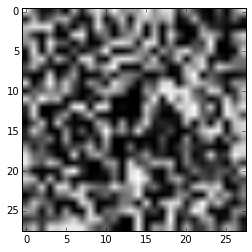

In [742]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray", vmin=0, vmax=1 )

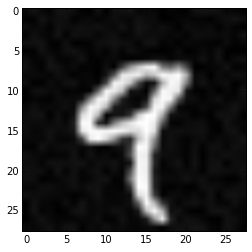

In [94]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray" )

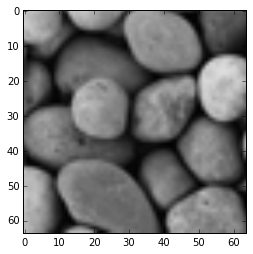

In [167]:
plt.imshow(rock[0][0], cmap="gray", vmin=0, vmax=1)

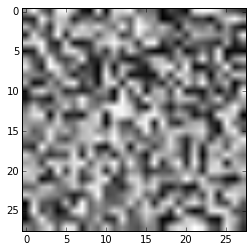

In [92]:
plt.imshow( cn["Y"].get_value()[0][0], cmap="gray" )

----

In [479]:
tmp = ((cn["get_outs"](Xt9[0:1])[5] - cn["get_outs"](Xt9[1:2])[5])**2)
print tmp
print tmp.shape

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   7.12289040e-09
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   7.34683969e-40 ...,   0.00000000e+00
    7.34683969e-40   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  2.15307125e-08   9.60487979e-08   1.15607042e-08 ...,   6.72394586e-09
    3.21585563e-09   1.30569380e-08]
 [  0.00000000e+00   0.00000000e+00   7.34683969e-40 ...,   1.76958584e-08
    6.29296339e-09   1.83670992e-40]
 [  3.65787143e-09   1.47399938e-08   3.19994066e-08 ...,   5.15531554e-08
    1.96932447e-09   6.18522485e-08]]
(128, 9)


In [600]:
for id_ in range(0,5):
    print np.min( cn["get_outs"](Xt9[0:1])[id_] ), np.max( cn["get_outs"](Xt9[0:1])[id_] ) 

0.0 0.99609375
-8.881784197e-16 14.0212289087
-0.810309813254 5.51160508522
-0.810309813254 5.51160508522
-1.4155343564e-15 51.2646680051


In [133]:
get_output(cn["l_out"], theano.shared( np.zeros( (1,1,28,28) ) ) )

Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0

In [83]:
?Xt9.flatten()

In [181]:
np.dot( np.ones( (10, 20) ).T, np.ones( (10, 20) ) ).shape

(20, 20)

In [271]:
np.ones( (20, 20) ).flatten().mean()

1.0

-----

In [590]:
def conv_net_2(input_shape=(1,1,28,28), umin=0, umax=1):
    
    nonlinearity=rectify
    l_in = InputLayer(input_shape)
    
    l_conv1 = Conv2DLayer(l_in, num_filters=16, filter_size=(3,3), nonlinearity=nonlinearity)
    l_mp1 = MaxPool2DLayer(l_conv1, pool_size=(2,2))
    
    l_conv2 = Conv2DLayer(l_mp1, num_filters=32, filter_size=(3,3), nonlinearity=nonlinearity)
    l_mp2 = MaxPool2DLayer(l_conv2, pool_size=(2,2))
    
    l_fc = DenseLayer(l_mp2, num_units=64)
    
    l_inv1 = InverseLayer(l_fc, l_fc)
    l_inv2 = InverseLayer(l_inv1, l_mp2)
    l_inv3 = InverseLayer(l_inv2, l_conv2)
    l_inv4 = InverseLayer(l_inv3, l_mp1)
    l_inv5 = InverseLayer(l_inv4, l_conv1)
    
    l_out = l_inv5
    sys.stderr.write("number of params: %i\n" % count_params(l_out))
    for layer in get_all_layers(l_out):
        print layer, layer.output_shape
    

    Y = T.tensor4('Y')
    X = theano.shared( np.random.uniform(umin, umax, size=input_shape ) )
    
    loss_fn = squared_error(
        X, get_output(l_out, Y, deterministic=True)
    ).mean()

    updates = nesterov_momentum(loss_fn, get_all_params(l_out) + [X], 0.01, 0.9)

    train = theano.function([Y], loss_fn, updates=updates)
    return {"l_out": l_out, "train": train, "X": X}

In [591]:
cn2 = conv_net_2()

<lasagne.layers.input.InputLayer object at 0x1334cf4d0> (1, 1, 28, 28)
<lasagne.layers.conv.Conv2DLayer object at 0x1334cf650> (1, 16, 26, 26)
<lasagne.layers.pool.MaxPool2DLayer object at 0x1334cf5d0> (1, 16, 13, 13)
<lasagne.layers.conv.Conv2DLayer object at 0x1334cf850> (1, 32, 11, 11)
<lasagne.layers.pool.MaxPool2DLayer object at 0x1334cf510> (1, 32, 5, 5)
<lasagne.layers.dense.DenseLayer object at 0x12bba7d50> (1, 64)
<lasagne.layers.special.InverseLayer object at 0x136bce050> (1, 32, 5, 5)
<lasagne.layers.special.InverseLayer object at 0x12bba7690> (1, 32, 11, 11)
<lasagne.layers.special.InverseLayer object at 0x12bba7c90> (1, 16, 13, 13)
<lasagne.layers.special.InverseLayer object at 0x12bba7d90> (1, 16, 26, 26)
<lasagne.layers.special.InverseLayer object at 0x12bba74d0> (1, 1, 28, 28)


number of params: 56064


In [594]:
for i in range(0, 1):
    print cn2["train"](Xt9[0:1])

nan


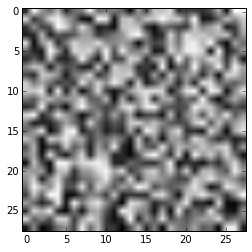

In [580]:
plt.imshow(cn2["X"].get_value()[0][0], cmap='gray')